In [1]:
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, AutoDateLocator
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from mapie.regression import MapieTimeSeriesRegressor

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

In [2]:
# Leitura dos Dados

df_bf = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Botafogo\Botafogo-2015-2023_Semanal_Dengue.xlsx')
df_cd = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Cidade de Deus\CidadeDeDeus-2015-2023_Semanal_Dengue.xlsx')
df_cp = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Copacabana\Copacabana-2015-2023_Semanal_Dengue.xlsx')
df_ed = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Engenho de Dentro\EngenhoDeDentro-2015-2023_Semanal_Dengue.xlsx')
df_ip = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Ipanema\Ipanema-2015-2023_Semanal_Dengue.xlsx')
df_lj = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Laranjeiras\Laranjeiras-2015-2023_Semanal_Dengue.xlsx')
df_mc = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Maracana\Maracana-2015-2023_Semanal_Dengue.xlsx')
df_rc = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Rocinha\Rocinha-2015-2023_Semanal_Dengue.xlsx')
df_vm = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Vila Militar\VilaMilitar-2015-2023_Semanal_Dengue.xlsx')
df_rl = pd.read_excel('D:\Mestrado\Defesa\Clima - Bairros RJ\Realengo\Realengo-2015-2023_Semanal_Dengue.xlsx')

In [3]:
# Definir a coluna de datas como índice e garantir o tipo datetime
def prepare_dataframe(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df.set_index('data', inplace=True)
    return df

In [4]:
# Concatenação dos dados

dataframes = [prepare_dataframe(df) for df in [df_bf, df_cd, df_cp, df_ed, df_ip, df_lj, df_mc, df_rc, df_vm, df_rl]]
data = pd.concat(dataframes)

In [5]:
# OneHotEncoder na coluna Bairro
data = pd.get_dummies(data, columns=['bairro'])

In [6]:
# Variáveis Exógenas
exg = ['chuva', 'temperaturaMedia', 'temperaturaMaxima','temperaturaMinima', 'direcaoVento',
       'velocidadeVento', 'pressaoAtmosferica', 'semana','bairro_Botafogo',
       'bairro_Cidade de Deus', 'bairro_Copacabana',
       'bairro_Engenho de Dentro', 'bairro_Ipanema', 'bairro_Laranjeiras',
       'bairro_Maracana', 'bairro_Realengo', 'bairro_Rocinha',
       'bairro_Vila Militar']

In [7]:
data.sort_index(inplace=True)

# Manter uma cópia dos dados com índice de datas
data_with_dates = data.copy()

# Resetar o índice para a previsão autorregressiva
data.reset_index(drop=True, inplace=True)

In [8]:
# Split dos dados - train-test
steps = 1050
data_train = data[:-steps]
data_test  = data[-steps:]

data_train_dates = data_with_dates.iloc[:-steps]
data_test_dates  = data_with_dates.iloc[-steps:]

print(f"Train dates : {data_train_dates.index.min()} --- {data_train_dates.index.max()}  (n={len(data_train_dates)})")
print(f"Test dates  : {data_test_dates.index.min()} --- {data_test_dates.index.max()}  (n={len(data_test_dates)})")

Train dates : 2015-01-04 00:00:00 --- 2021-12-26 00:00:00  (n=3650)
Test dates  : 2022-01-02 00:00:00 --- 2023-12-31 00:00:00  (n=1050)


In [9]:
bairros = ['Botafogo', 'Cidade de Deus', 'Copacabana', 'Engenho de Dentro', 
           'Ipanema', 'Laranjeiras', 'Maracana', 'Realengo', 'Rocinha', 'Vila Militar']

# PREVISÃO AUTORREGRESSIVA

In [10]:
# Previsão Autorregressiva
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 80
             )

forecaster.fit(y=data_train['dengueChikungunya'], exog=data_train[exg])

predictions = forecaster.predict(steps=steps, exog=data_test[exg])

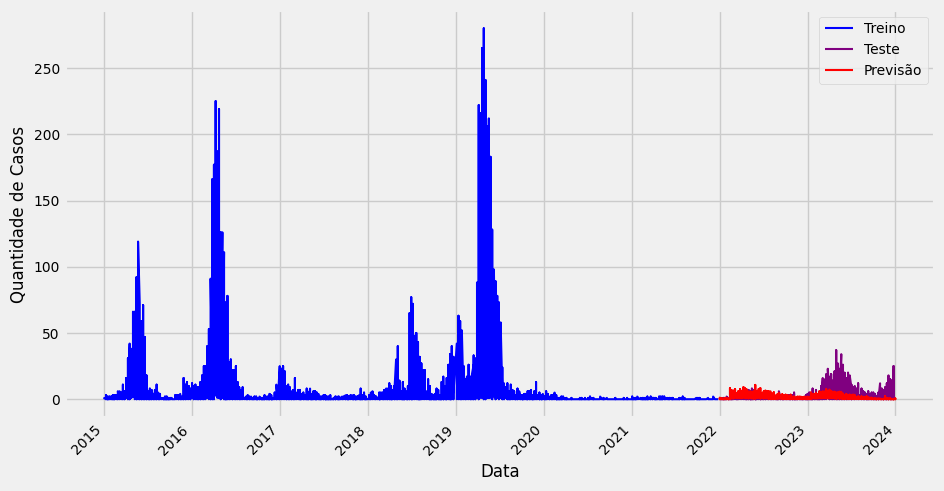

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando os dados de treino, teste e previsão
data_train_dates['dengueChikungunya'].plot(ax=ax, label='Treino', color='blue')
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste', color='purple')
predictions.index = data_test_dates.index
predictions.plot(ax=ax, label='Previsão', color='red')

# Formatando o eixo X para mostrar os anos
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

# Definindo os rótulos dos eixos
ax.set_xlabel('Data')  # Rótulo do eixo X
ax.set_ylabel('Quantidade de Casos')  # Rótulo do eixo Y

# Mostrando a legenda
ax.legend()

# Rotacionando os rótulos do eixo X para melhorar a legibilidade
plt.xticks(rotation=45)

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_autorreg_treinoTeste_semIC.png', dpi=300)

# Exibindo o gráfico
plt.show()

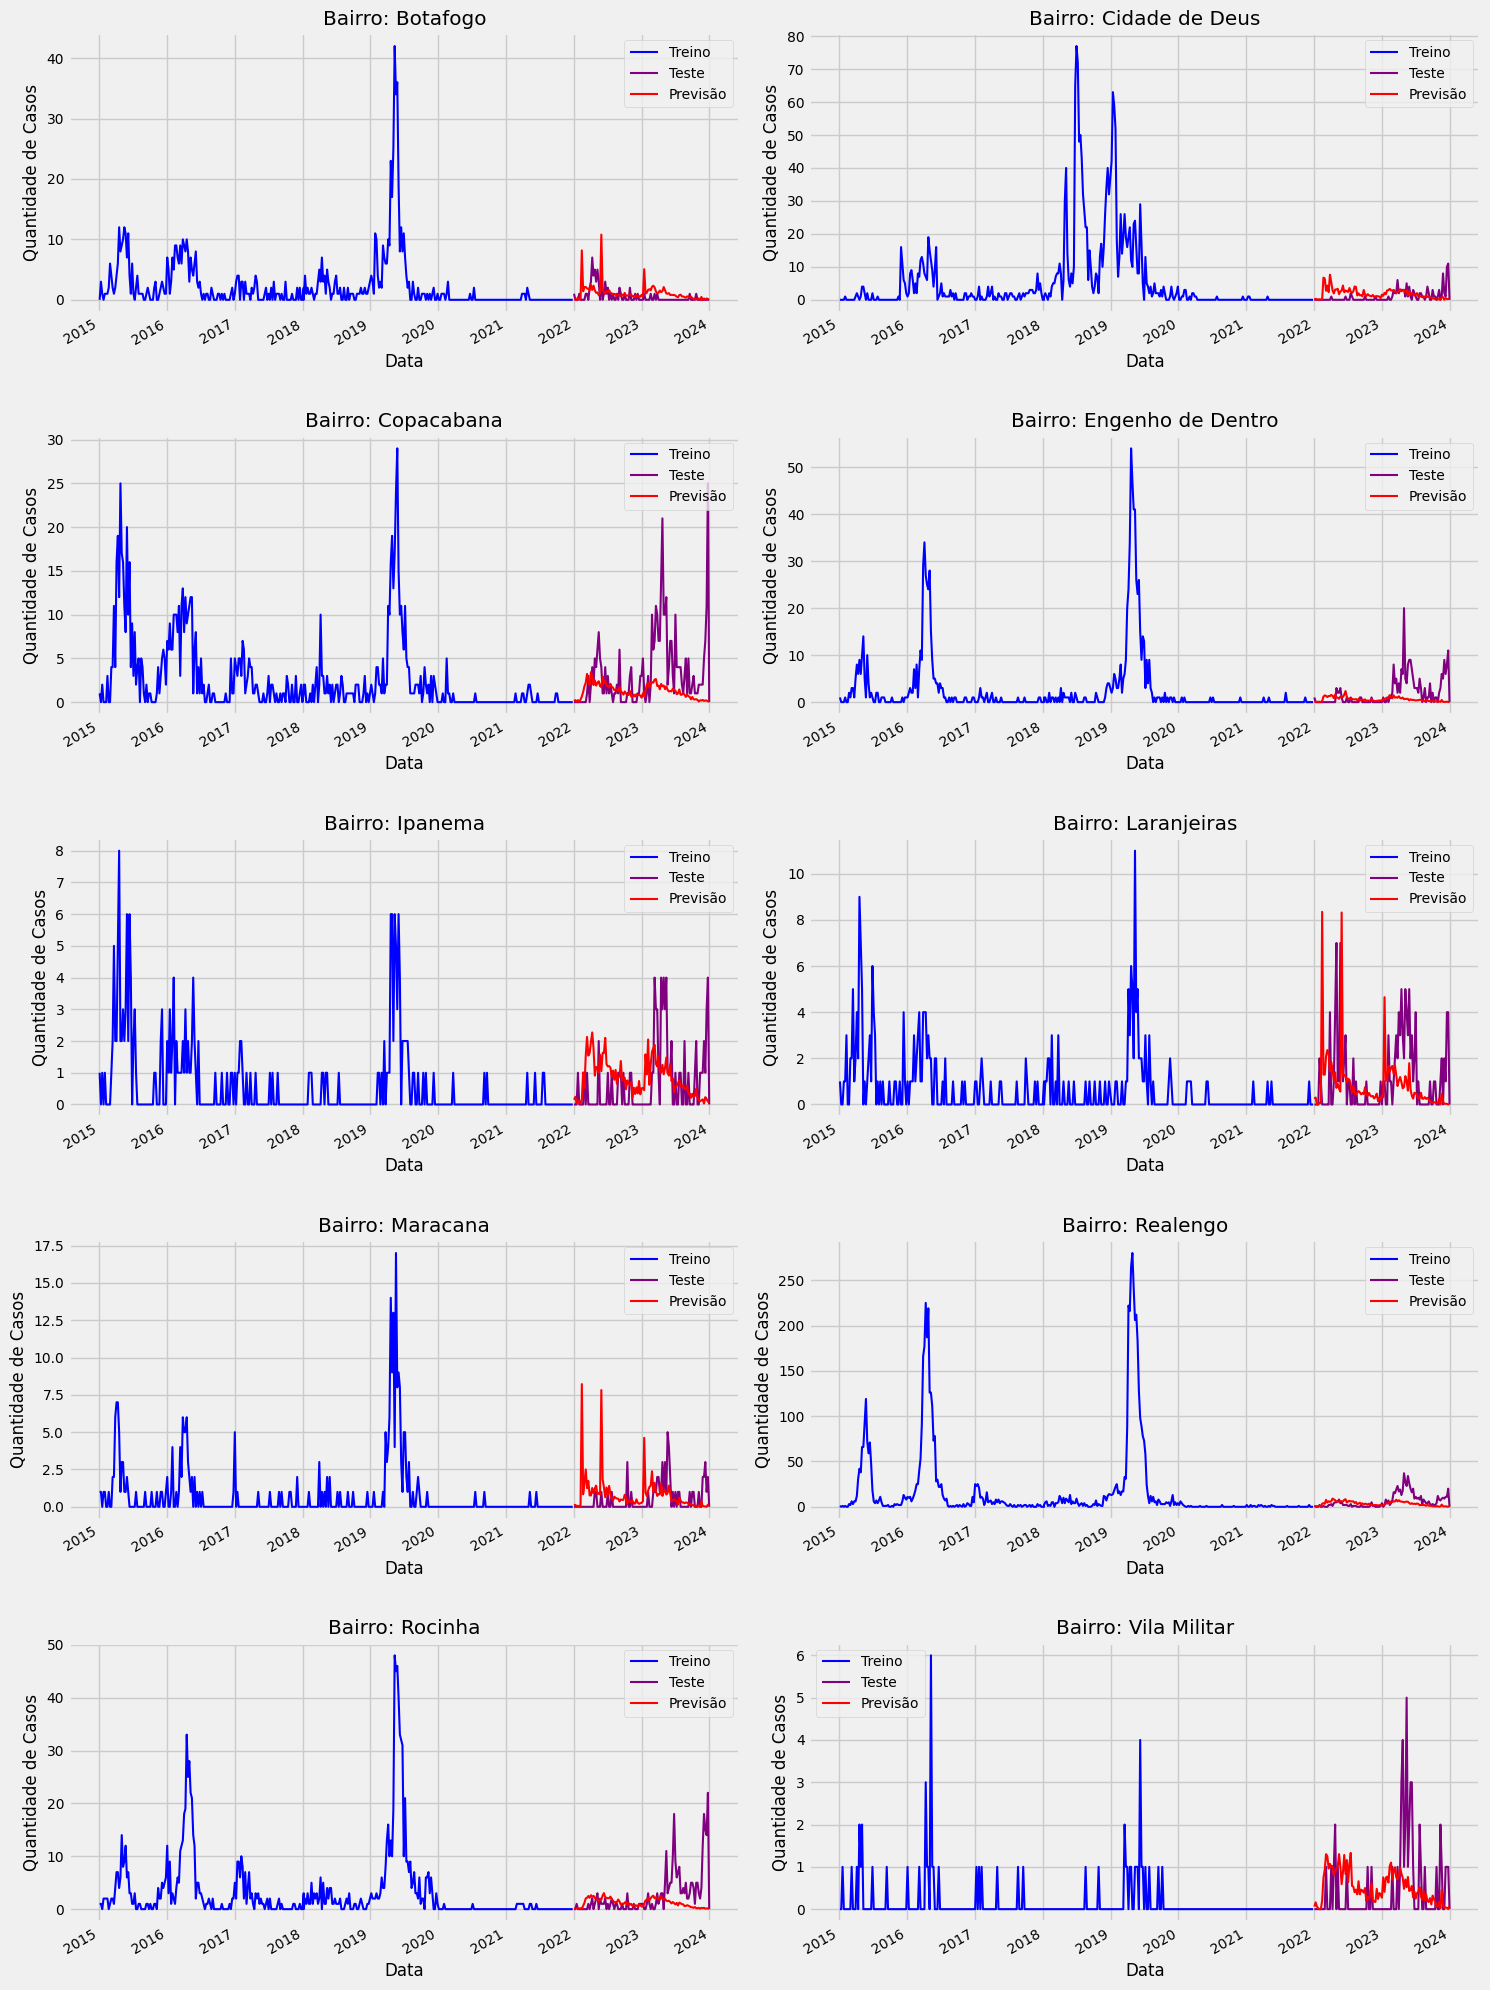

In [12]:
fig, axes = plt.subplots(len(bairros) // 2 + len(bairros) % 2, 2, figsize=(15, len(bairros) * 2), sharex=False)
axes = axes.flatten()

for i, bairro in enumerate(bairros):
    ax = axes[i]
    
    # Filtrar valores reais e previsões para o bairro específico
    mask_train = data_train_dates[f'bairro_{bairro}'] == 1
    mask_test = data_test_dates[f'bairro_{bairro}'] == 1
    
    real_train_values = data_train_dates.loc[mask_train, 'dengueChikungunya']
    real_test_values = data_test_dates.loc[mask_test, 'dengueChikungunya']
    predicted_values = predictions[mask_test]
    
    # Plotando os dados de treino, teste e previsão para o bairro
    real_train_values.plot(ax=ax, label='Treino', color='blue')
    real_test_values.plot(ax=ax, label='Teste', color='purple')
    predicted_values.plot(ax=ax, label='Previsão', color='red')
    
    # Formatando o eixo X para mostrar os anos
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    
    # Definindo os rótulos dos eixos
    ax.set_xlabel('Data')
    ax.set_ylabel('Quantidade de Casos')
    ax.set_title(f'Bairro: {bairro}')
    
    # Mostrar a legenda
    ax.legend()

# Remover quaisquer eixos vazios
for j in range(len(bairros), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição de títulos e rótulos
plt.tight_layout(h_pad=3.0)

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_autorreg_treinoTeste_semIC_bairros.png', dpi=300)

# Exibindo o gráfico
plt.show()

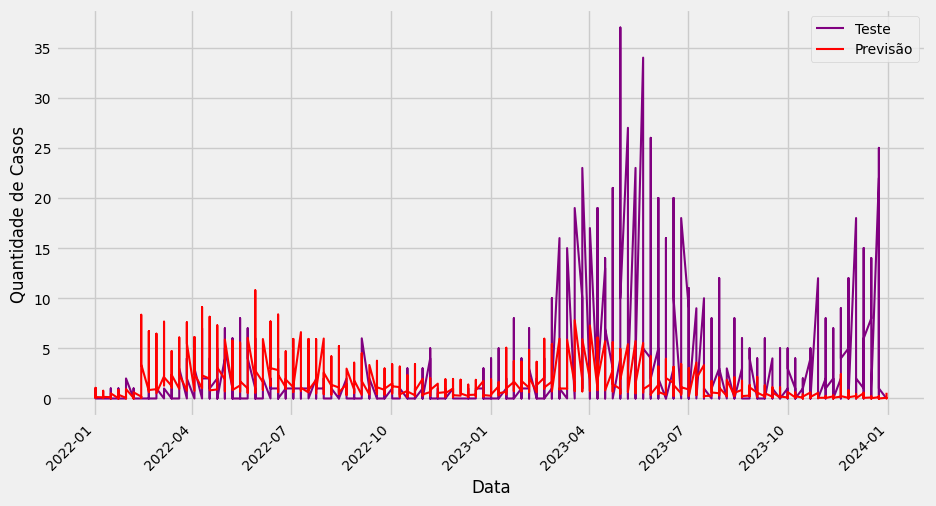

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando os dados de treino, teste e previsão
#data_train_dates['dengueChikungunya'].plot(ax=ax, label='Treino')
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste', color='purple')
predictions.index = data_test_dates.index
predictions.plot(ax=ax, label='Previsão', color='red')

# Formatando o eixo X para mostrar os anos
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Definindo os rótulos dos eixos
ax.set_xlabel('Data')  # Rótulo do eixo X
ax.set_ylabel('Quantidade de Casos')  # Rótulo do eixo Y

# Mostrando a legenda
ax.legend()

# Rotacionando os rótulos do eixo X para melhorar a legibilidade
plt.xticks(rotation=45)

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_autorreg_teste_semIC.png', dpi=300)

# Exibindo o gráfico
plt.show()

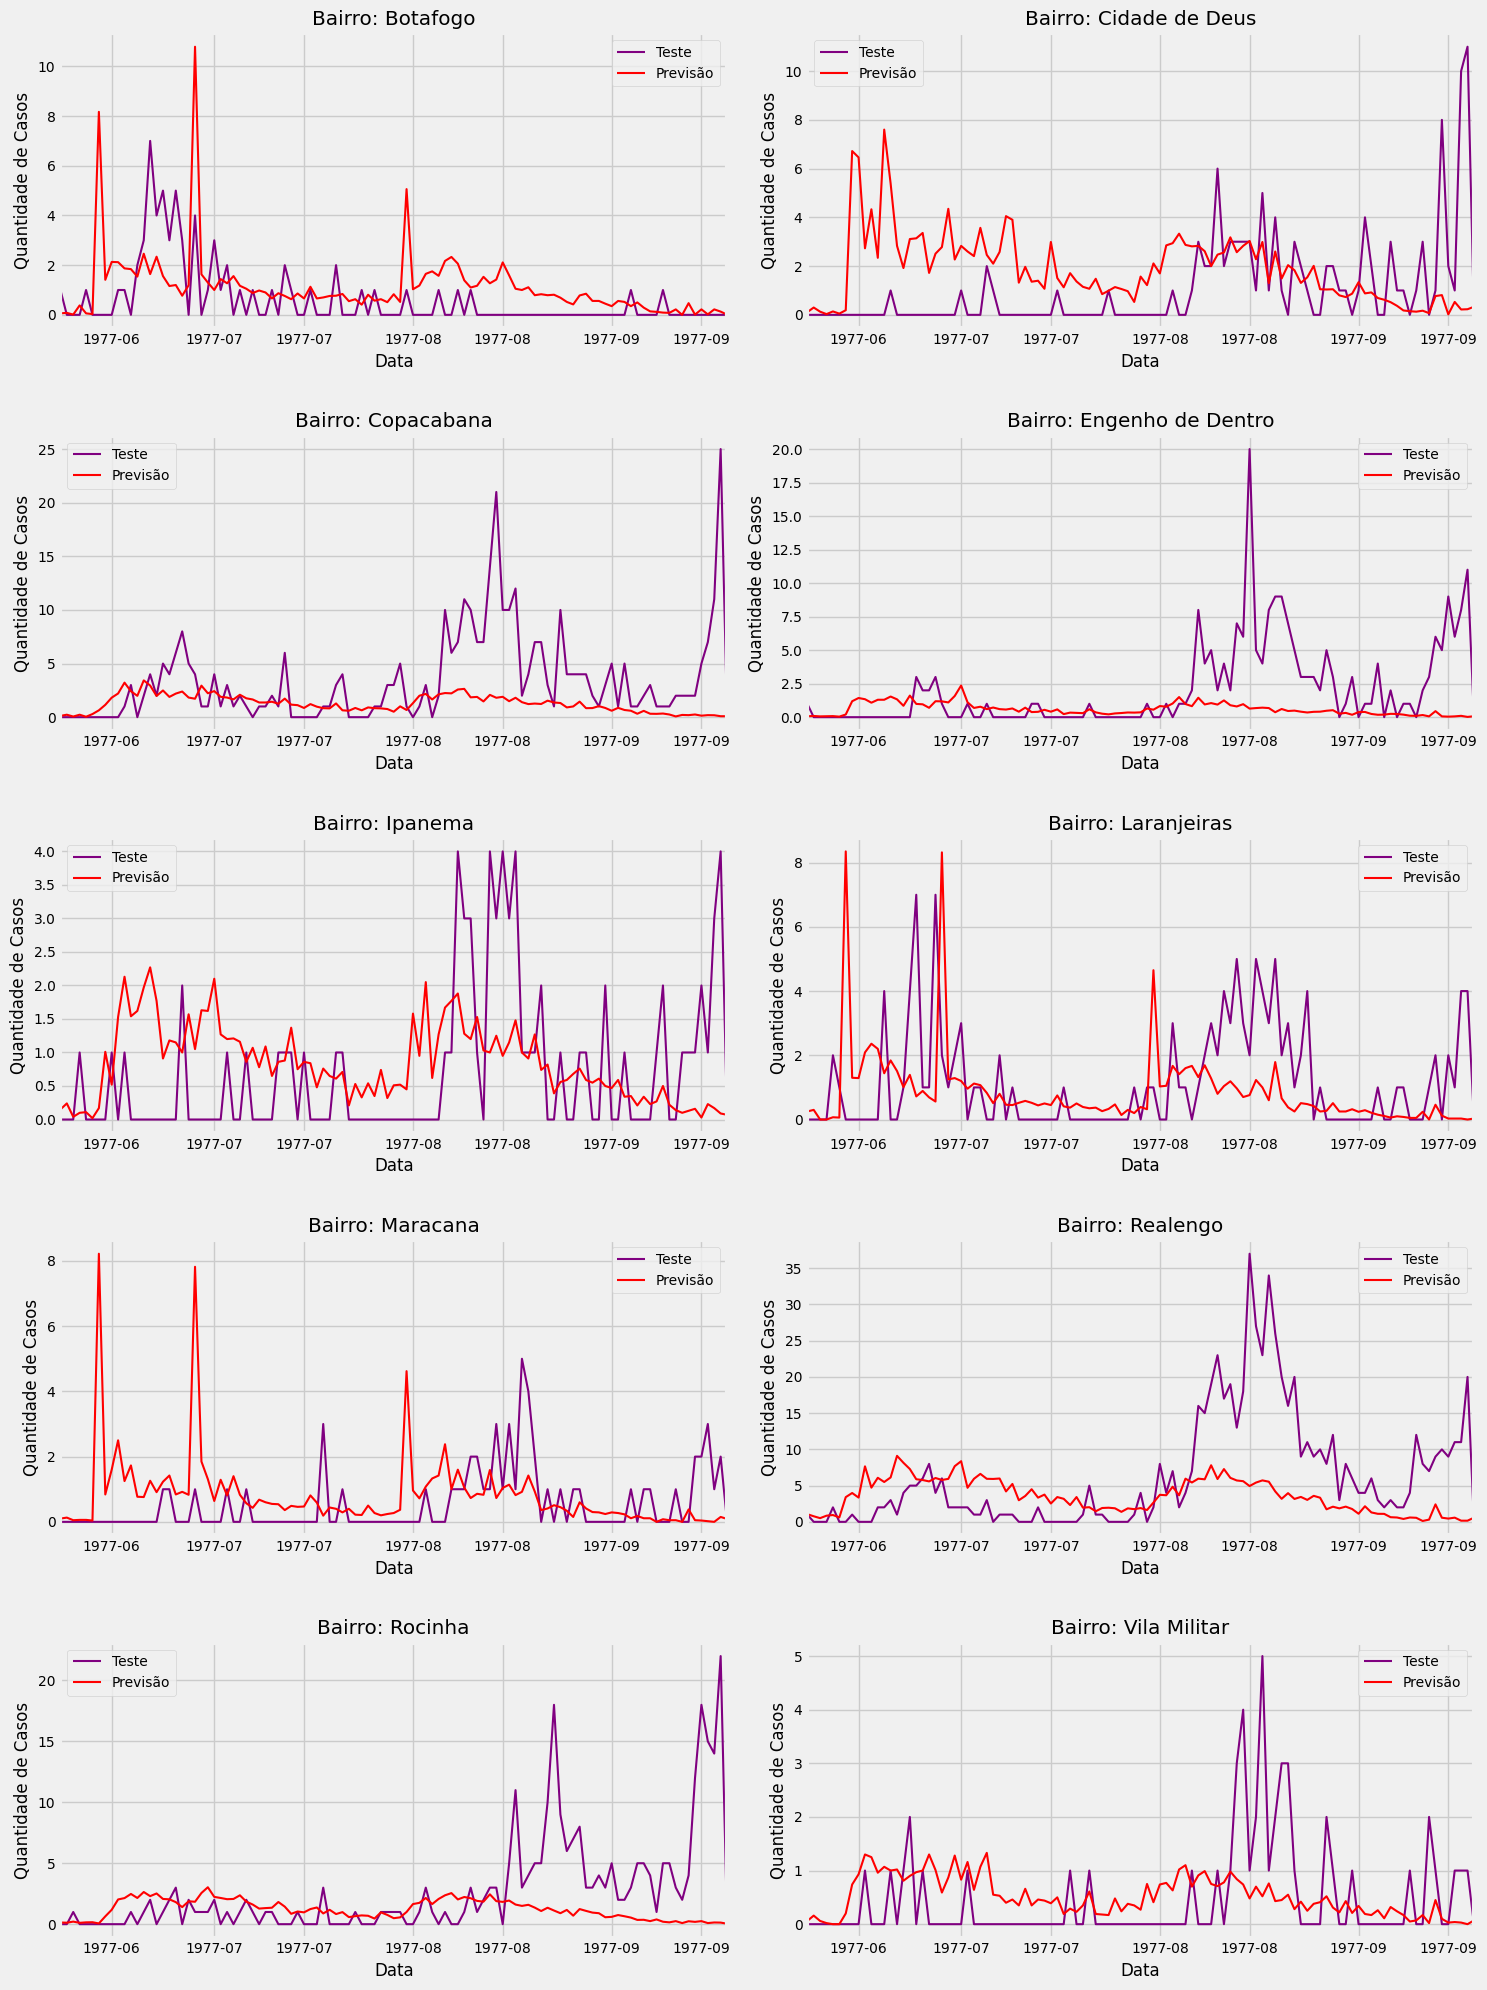

In [14]:
fig, axes = plt.subplots(len(bairros) // 2 + len(bairros) % 2, 2, figsize=(15, len(bairros) * 2), sharex=False)
axes = axes.flatten()

# Garantir que as previsões e os dados de teste tenham o mesmo índice
predictions.index = pd.to_datetime(data_test_dates.index)
data_test_dates.index = pd.to_datetime(data_test_dates.index)
data_train_dates.index = pd.to_datetime(data_train_dates.index)

# Filtrar as datas corretas para garantir que são de 2022 e 2023
data_test_dates = data_test_dates[(data_test_dates.index.year >= 2022) & (data_test_dates.index.year <= 2023)]
predictions = predictions[(predictions.index.year >= 2022) & (predictions.index.year <= 2023)]

for i, bairro in enumerate(bairros):
    ax = axes[i]
    
    # Filtrar valores reais e previsões para o bairro específico
    mask_test = data_test_dates[f'bairro_{bairro}'] == 1
    
    real_test_values = data_test_dates.loc[mask_test, 'dengueChikungunya']
    predicted_values = predictions.loc[mask_test]
    
    # Plotando os dados de teste e previsão para o bairro
    real_test_values.plot(ax=ax, label='Teste', color='purple')
    predicted_values.plot(ax=ax, label='Previsão', color='red')
    
    # Formatando o eixo X para mostrar os anos corretamente
    ax.set_xlim(real_test_values.index.min(), real_test_values.index.max())
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    # Definindo os rótulos dos eixos
    ax.set_xlabel('Data')  # Rótulo para o eixo X
    ax.set_ylabel('Quantidade de Casos')  # Rótulo do eixo Y
    ax.set_title(f'Bairro: {bairro}')
    
    # Mostrar a legenda
    ax.legend()

# Remover quaisquer eixos vazios
for j in range(len(bairros), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição de títulos e rótulos
plt.tight_layout(h_pad=3.0)

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_autorreg_teste_semIC_bairros.png', dpi=300)

plt.show()

In [15]:
# Calculando o erro quadrático médio (MSE)
error_mse = mean_squared_error(
    y_true=data_test['dengueChikungunya'],
    y_pred=predictions
)

# Calculando o coeficiente de determinação R²
r2 = r2_score(
    y_true=data_test['dengueChikungunya'],
    y_pred=predictions
)

# Exibindo os resultados
print(f"Test error (MSE): {error_mse}")
print(f"Test R²: {r2}")

Test error (MSE): 14.139712952380952
Test R²: 0.038223127682530555


In [16]:
predictions_interval = forecaster.predict_interval(
                    steps = steps,
                    interval = [5, 95],
                    n_boot   = 500,
                    exog=data_test[exg]
              )

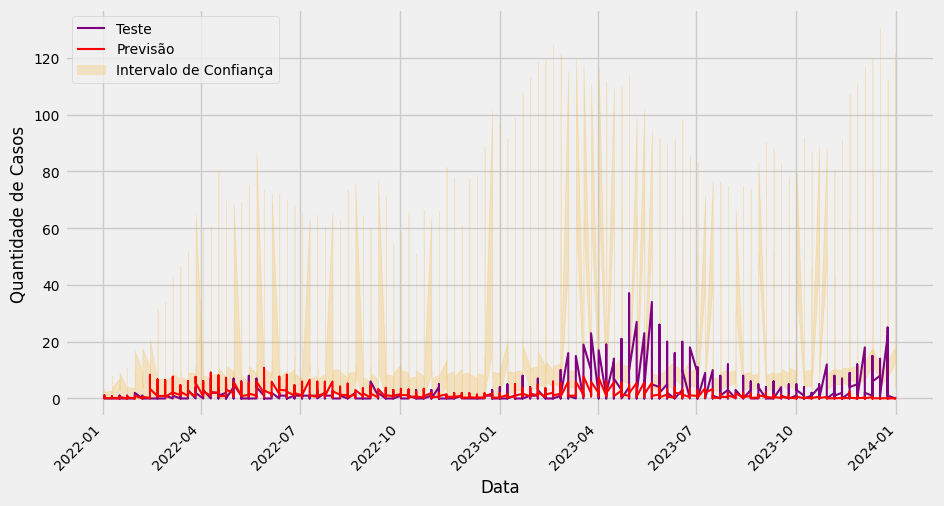

In [17]:
predictions.index = data_test_dates.index
predictions_interval.index = data_test_dates.index

fig, ax = plt.subplots(figsize=(10, 6))
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste', color='purple')
predictions.plot(ax=ax, label='Previsão', color='red')
ax.fill_between(
    predictions_interval.index,
    np.maximum(predictions_interval['lower_bound'], 0),
    predictions_interval['upper_bound'],
    color = 'orange',
    alpha = 0.2,
    label='Intervalo de Confiança'
)

# Formatando os eixos e rotacionando o eixo X
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Adicionando rótulos aos eixos
ax.set_xlabel('Data')  # Rótulo para o eixo X
ax.set_ylabel('Quantidade de Casos')  # Rótulo para o eixo Y

# Definindo a legenda no canto superior esquerdo
ax.legend(loc='upper left')

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_autorreg_teste_comIC.png', dpi=300)

plt.show()

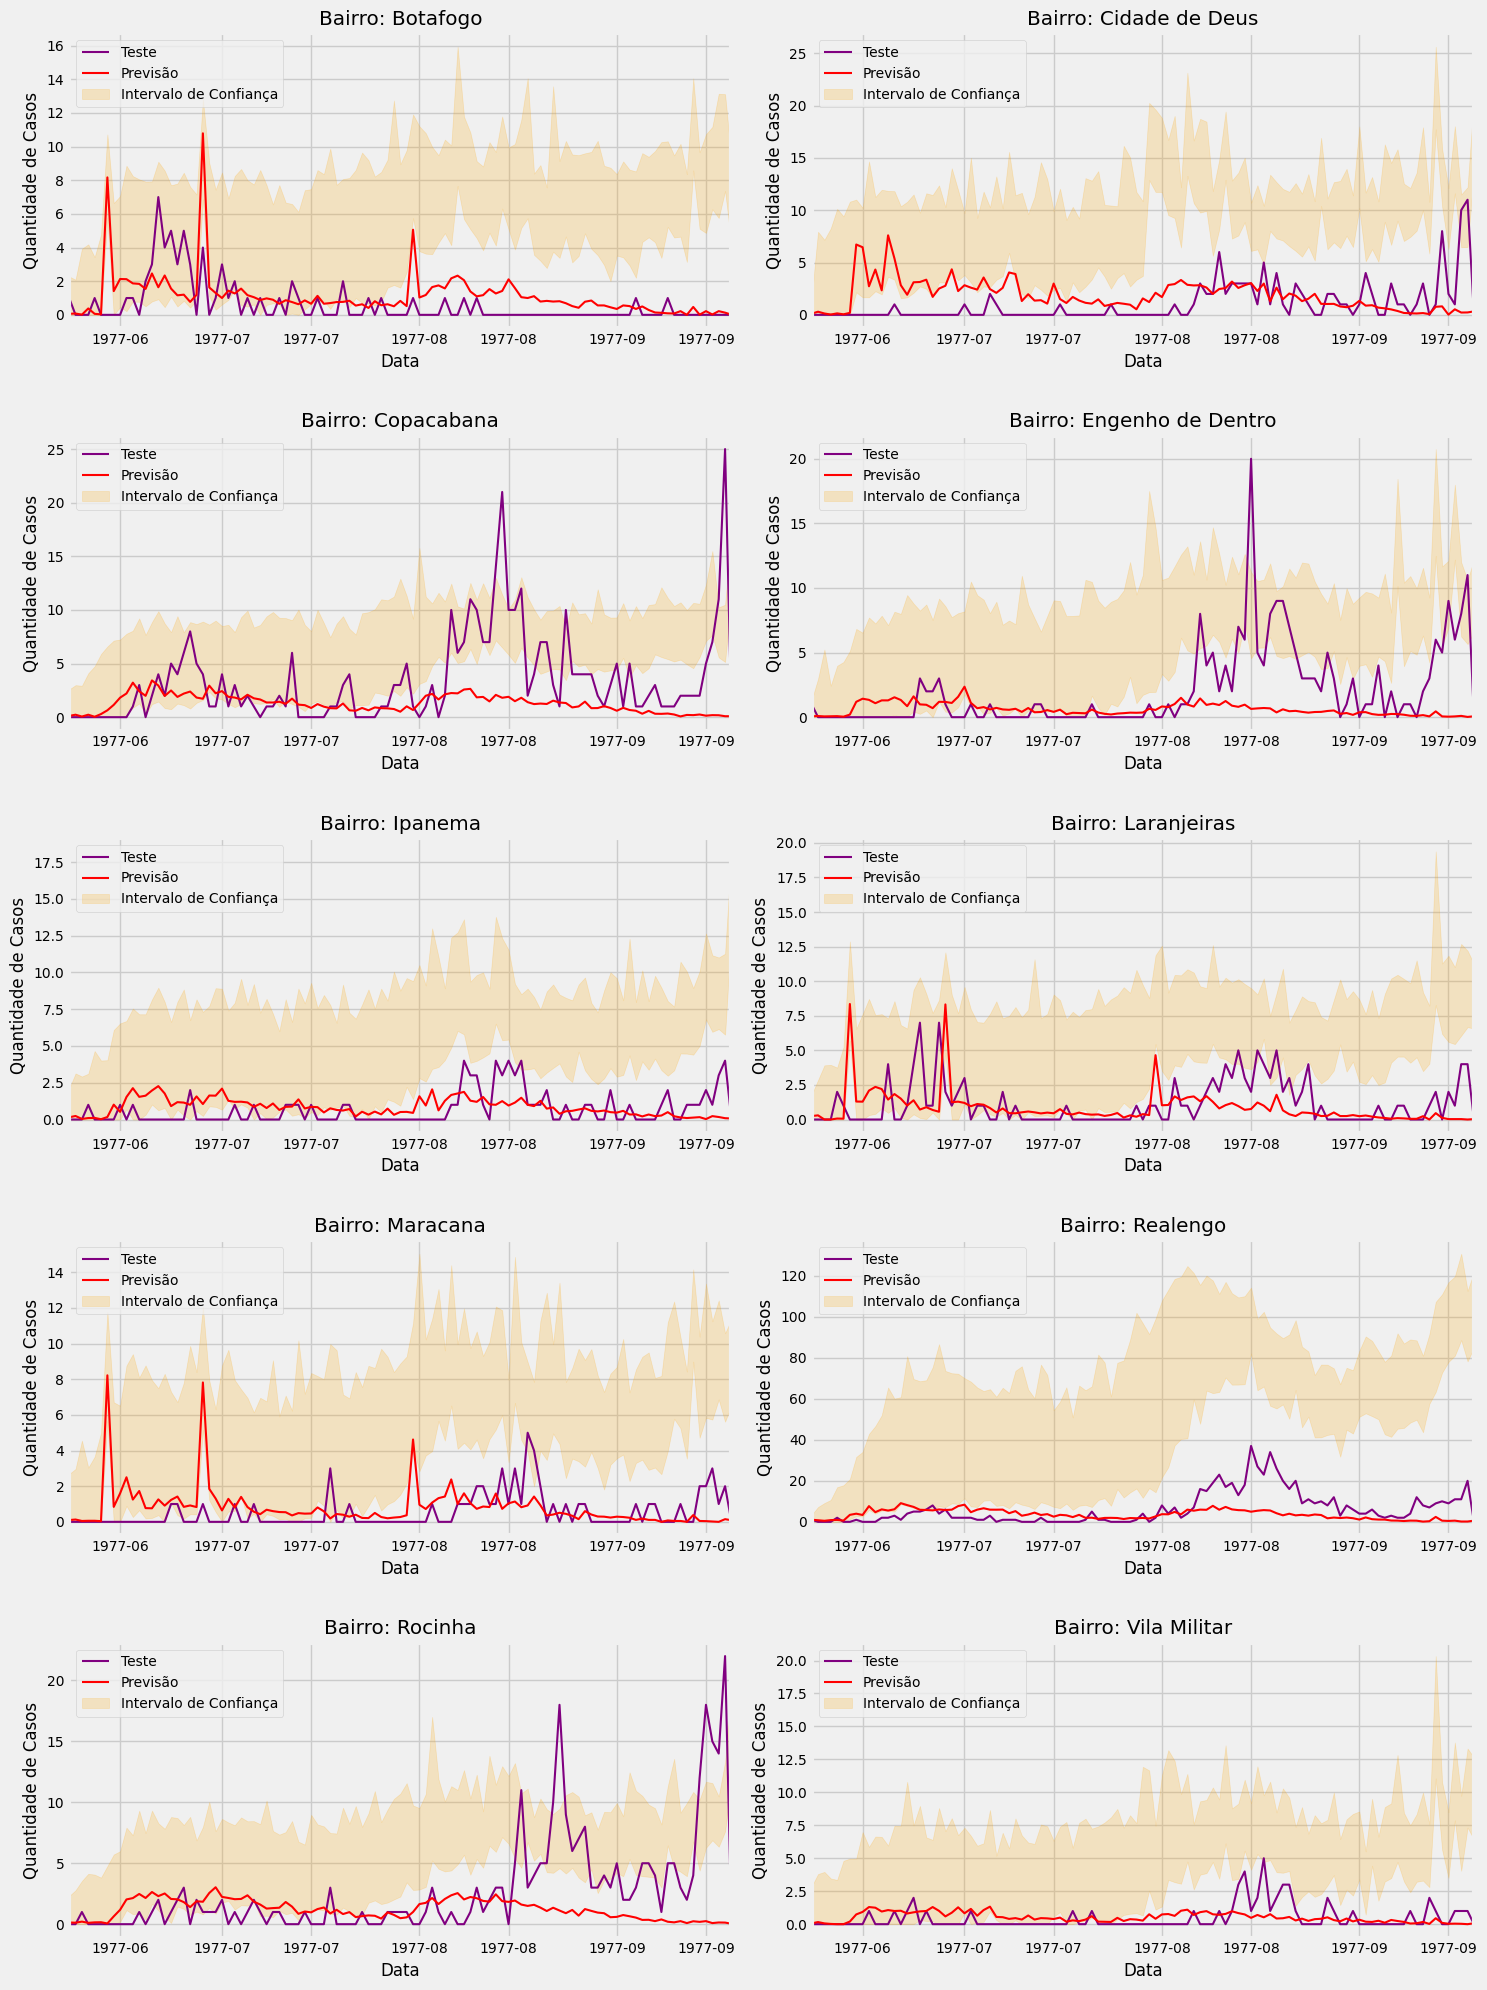

In [18]:
fig, axes = plt.subplots(len(bairros) // 2 + len(bairros) % 2, 2, figsize=(15, len(bairros) * 2), sharex=False)
axes = axes.flatten()

predictions.index = data_test_dates.index
predictions_interval.index = data_test_dates.index

for i, bairro in enumerate(bairros):
    ax = axes[i]
    
    # Filtrar valores reais, previsões e intervalos para o bairro específico
    mask_test = data_test_dates[f'bairro_{bairro}'] == 1
    
    real_test_values = data_test_dates.loc[mask_test, 'dengueChikungunya']
    predicted_values = predictions[mask_test]
    lower_bound = predictions_interval.loc[mask_test, 'lower_bound']
    upper_bound = predictions_interval.loc[mask_test, 'upper_bound']
    
    # Plotando os dados de teste, previsão e intervalo de confiança para o bairro
    real_test_values.plot(ax=ax, label='Teste', color='purple')
    predicted_values.plot(ax=ax, label='Previsão', color='red')
    ax.fill_between(
        real_test_values.index,
        np.maximum(lower_bound, 0),
        upper_bound,
        color='orange',
        alpha=0.2,
        label='Intervalo de Confiança'
    )
    
    # Formatando o eixo X para mostrar os anos
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    # Definindo os rótulos dos eixos
    ax.set_xlabel('Data')  # Rótulo do eixo X
    ax.set_ylabel('Quantidade de Casos')  # Rótulo do eixo Y
    ax.set_title(f'Bairro: {bairro}')
    
    # Mostrar a legenda
    ax.legend(loc='upper left')

# Remover quaisquer eixos vazios
for j in range(len(bairros), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição de títulos e rótulos
plt.tight_layout(h_pad=3.0)

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_autorreg_teste_comIC_bairros.png', dpi=300)

plt.show()

In [19]:
# Calcular a média dos valores de dengueChikungunya no conjunto de treino
train_mean = data_train['dengueChikungunya'].mean()

# Criar previsões constantes usando a média do treino para o conjunto de teste
constant_predictions = np.full(len(data_test), train_mean)

# Calcular o MSE usando a média como previsão constante
mse_constant = mean_squared_error(data_test['dengueChikungunya'], constant_predictions)

# Calcular o R² do modelo autorregressivo
r2_autoregressive = r2_score(data_test['dengueChikungunya'], predictions)

# Calcular o R² usando a média do conjunto de treino como previsão constante
r2_constant = r2_score(data_test['dengueChikungunya'], constant_predictions)

# Imprimir os resultados de MSE e R²
print(f"MSE do modelo autorregressivo: {error_mse:.2f}")
print(f"MSE usando a média do conjunto de treino como previsão: {mse_constant:.2f}")

print(f"R² do modelo autorregressivo: {r2_autoregressive:.2f}")
print(f"R² usando a média do conjunto de treino como previsão: {r2_constant:.2f}")

# Comparação dos resultados
if error_mse < mse_constant:
    print("O modelo autorregressivo performa melhor do que usar a média do conjunto de treino como previsão.")
else:
    print("Usar a média do conjunto de treino como previsão performa similarmente ou melhor do que o modelo autorregressivo.")


if r2_autoregressive > r2_constant:
    print("O modelo autorregressivo performa melhor do que usar a média do conjunto de treino como previsão.")
else:
    print("Usar a média do conjunto de treino como previsão performa similarmente ou melhor do que o modelo autorregressivo.")

MSE do modelo autorregressivo: 14.14
MSE usando a média do conjunto de treino como previsão: 17.35
R² do modelo autorregressivo: 0.04
R² usando a média do conjunto de treino como previsão: -0.18
O modelo autorregressivo performa melhor do que usar a média do conjunto de treino como previsão.
O modelo autorregressivo performa melhor do que usar a média do conjunto de treino como previsão.


In [20]:
# Obter limites inferiores e superiores dos intervalos de confiança
lower_bound = predictions_interval['lower_bound']
upper_bound = predictions_interval['upper_bound']

# Valores reais
true_values = data_test_dates['dengueChikungunya']  # Usar o dataframe com as datas para manter o índice de data

# Alinhar os índices para garantir compatibilidade
true_values, lower_bound = true_values.align(lower_bound, join='inner')
true_values, upper_bound = true_values.align(upper_bound, join='inner')

# Verificar se os valores reais estão dentro dos intervalos
within_interval = (true_values >= lower_bound) & (true_values <= upper_bound)

# Calcular a cobertura como a proporção de valores dentro do intervalo
coverage = within_interval.sum() / len(true_values)

print(f'Cobertura do Intervalo de Confiança: {coverage:.2%}')

Cobertura do Intervalo de Confiança: 25.43%


## Analise por Bairro - Autorreg

In [21]:
predictions.index = data_test_dates.index

mse_por_bairro = {}
r2_por_bairro = {}

In [22]:
for bairro in bairros:
    # Filtrar valores reais e previsões para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    predicted_values = predictions[mask]
    
    # Calcular o MSE e o R² para o bairro
    mse = mean_squared_error(y_true=real_values, y_pred=predicted_values)
    r2 = r2_score(y_true=real_values, y_pred=predicted_values)
    
    # Armazenar os resultados
    mse_por_bairro[bairro] = mse
    r2_por_bairro[bairro] = r2

In [23]:
# Exibir os MSEs e R² por bairro
print("MSE por bairro:")
for bairro, mse in mse_por_bairro.items():
    print(f"{bairro}: MSE = {mse:.2f}")

print("\nR² por bairro:")
for bairro, r2 in r2_por_bairro.items():
    print(f"{bairro}: R² = {r2:.2f}")

MSE por bairro:
Botafogo: MSE = 2.69
Cidade de Deus: MSE = 7.23
Copacabana: MSE = 21.76
Engenho de Dentro: MSE = 12.37
Ipanema: MSE = 1.41
Laranjeiras: MSE = 3.93
Maracana: MSE = 2.41
Realengo: MSE = 66.76
Rocinha: MSE = 21.91
Vila Militar: MSE = 0.91

R² por bairro:
Botafogo: R² = -0.74
Cidade de Deus: R² = -0.94
Copacabana: R² = -0.22
Engenho de Dentro: R² = -0.24
Ipanema: R² = -0.21
Laranjeiras: R² = -0.52
Maracana: R² = -1.69
Realengo: R² = -0.10
Rocinha: R² = -0.27
Vila Militar: R² = -0.10


In [24]:
# Garantir que os índices de predictions_interval estejam alinhados com os dados reais
predictions_interval.index = data_test_dates.index

cobertura_por_bairro = {}

for bairro in bairros:
    # Filtrar valores reais e intervalos para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    
    # Garantir que a máscara não esteja vazia
    if mask.sum() == 0:
        print(f"Atenção: Nenhum dado encontrado para o bairro {bairro}.")
        cobertura_por_bairro[bairro] = None
        continue

    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    lower_bound = predictions_interval.loc[mask, 'lower_bound']
    upper_bound = predictions_interval.loc[mask, 'upper_bound']
    
    # Checando o alinhamento dos índices
    if not real_values.index.equals(lower_bound.index):
        print(f"Desalinhamento de índices encontrado no bairro {bairro}. Realinhando os dados...")
        real_values = real_values.reindex(lower_bound.index)
    
    # Verificar se os valores reais estão dentro do intervalo de confiança
    inside_interval = (real_values >= lower_bound) & (real_values <= upper_bound)
    
    # Calcular a cobertura como a proporção de valores reais dentro do intervalo
    coverage = inside_interval.mean() * 100
    
    # Armazenar a cobertura
    cobertura_por_bairro[bairro] = coverage

# Exibir as coberturas por bairro
for bairro, coverage in cobertura_por_bairro.items():
    if coverage is not None:
        print(f"{bairro}: Cobertura do intervalo de confiança = {coverage:.2f}%")
    else:
        print(f"{bairro}: Cobertura do intervalo de confiança não calculada (dados ausentes).")

Botafogo: Cobertura do intervalo de confiança = 29.52%
Cidade de Deus: Cobertura do intervalo de confiança = 9.52%
Copacabana: Cobertura do intervalo de confiança = 40.00%
Engenho de Dentro: Cobertura do intervalo de confiança = 34.29%
Ipanema: Cobertura do intervalo de confiança = 20.95%
Laranjeiras: Cobertura do intervalo de confiança = 30.48%
Maracana: Cobertura do intervalo de confiança = 18.10%
Realengo: Cobertura do intervalo de confiança = 6.67%
Rocinha: Cobertura do intervalo de confiança = 33.33%
Vila Militar: Cobertura do intervalo de confiança = 31.43%


# MAPIE

In [25]:
# Inicialização MAPIE TimeSeriesRegressor
mapie_ts = MapieTimeSeriesRegressor(estimator=forecaster.regressor, method="enbpi")

In [26]:
# Fit MAPIE para train
mapie_ts.fit(data_train_dates[exg], data_train_dates['dengueChikungunya'])

# Predições com o intervalo
predictions_mapie, intervals = mapie_ts.predict(data_test_dates[exg], alpha=0.1)

In [27]:
# Certificando os intervalos com os formatos corretos
intervals = np.squeeze(np.asarray(intervals))

# Check the shape of intervals
print("Shape of intervals:", intervals.shape)

Shape of intervals: (1050, 2)


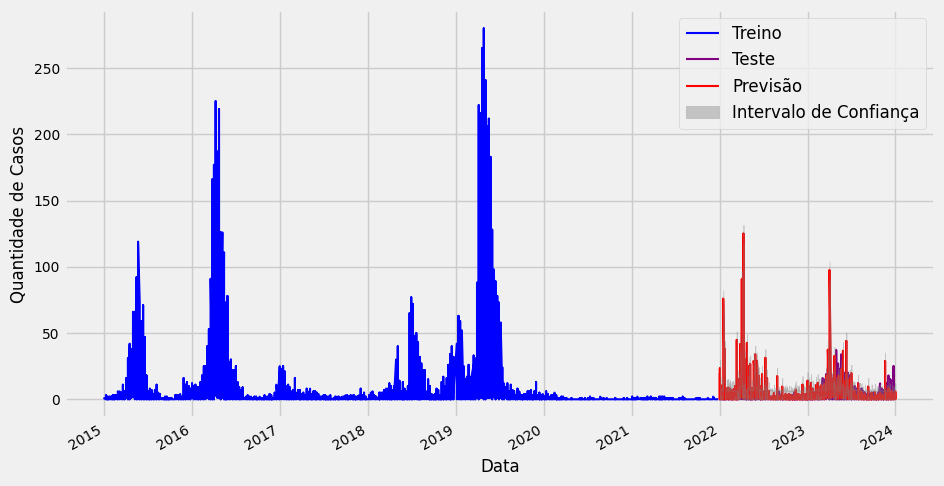

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando os dados de treino, teste e previsão
data_train_dates['dengueChikungunya'].plot(ax=ax, label='Treino', color='blue', zorder=1)
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste', color='purple', zorder=2)
ax.plot(data_test_dates.index, predictions_mapie, label='Previsão', color='red', zorder=3)

# Preenchendo o intervalo de confiança
if intervals.ndim == 2 and intervals.shape[1] == 2:
    ax.fill_between(data_test_dates.index, np.maximum(intervals[:, 0], 0), intervals[:, 1], color='gray', alpha=0.4, label='Intervalo de Confiança', zorder=4)

# Formatando os eixos e rotacionando o eixo X
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
fig.autofmt_xdate()

# Adicionando rótulos aos eixos
ax.set_xlabel('Data')  # Rótulo para o eixo X
ax.set_ylabel('Quantidade de Casos')  # Rótulo para o eixo Y

# Definindo a legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', fontsize='large')

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_mapie_treinoTeste.png', dpi=300)

# Exibindo o gráfico
plt.show()


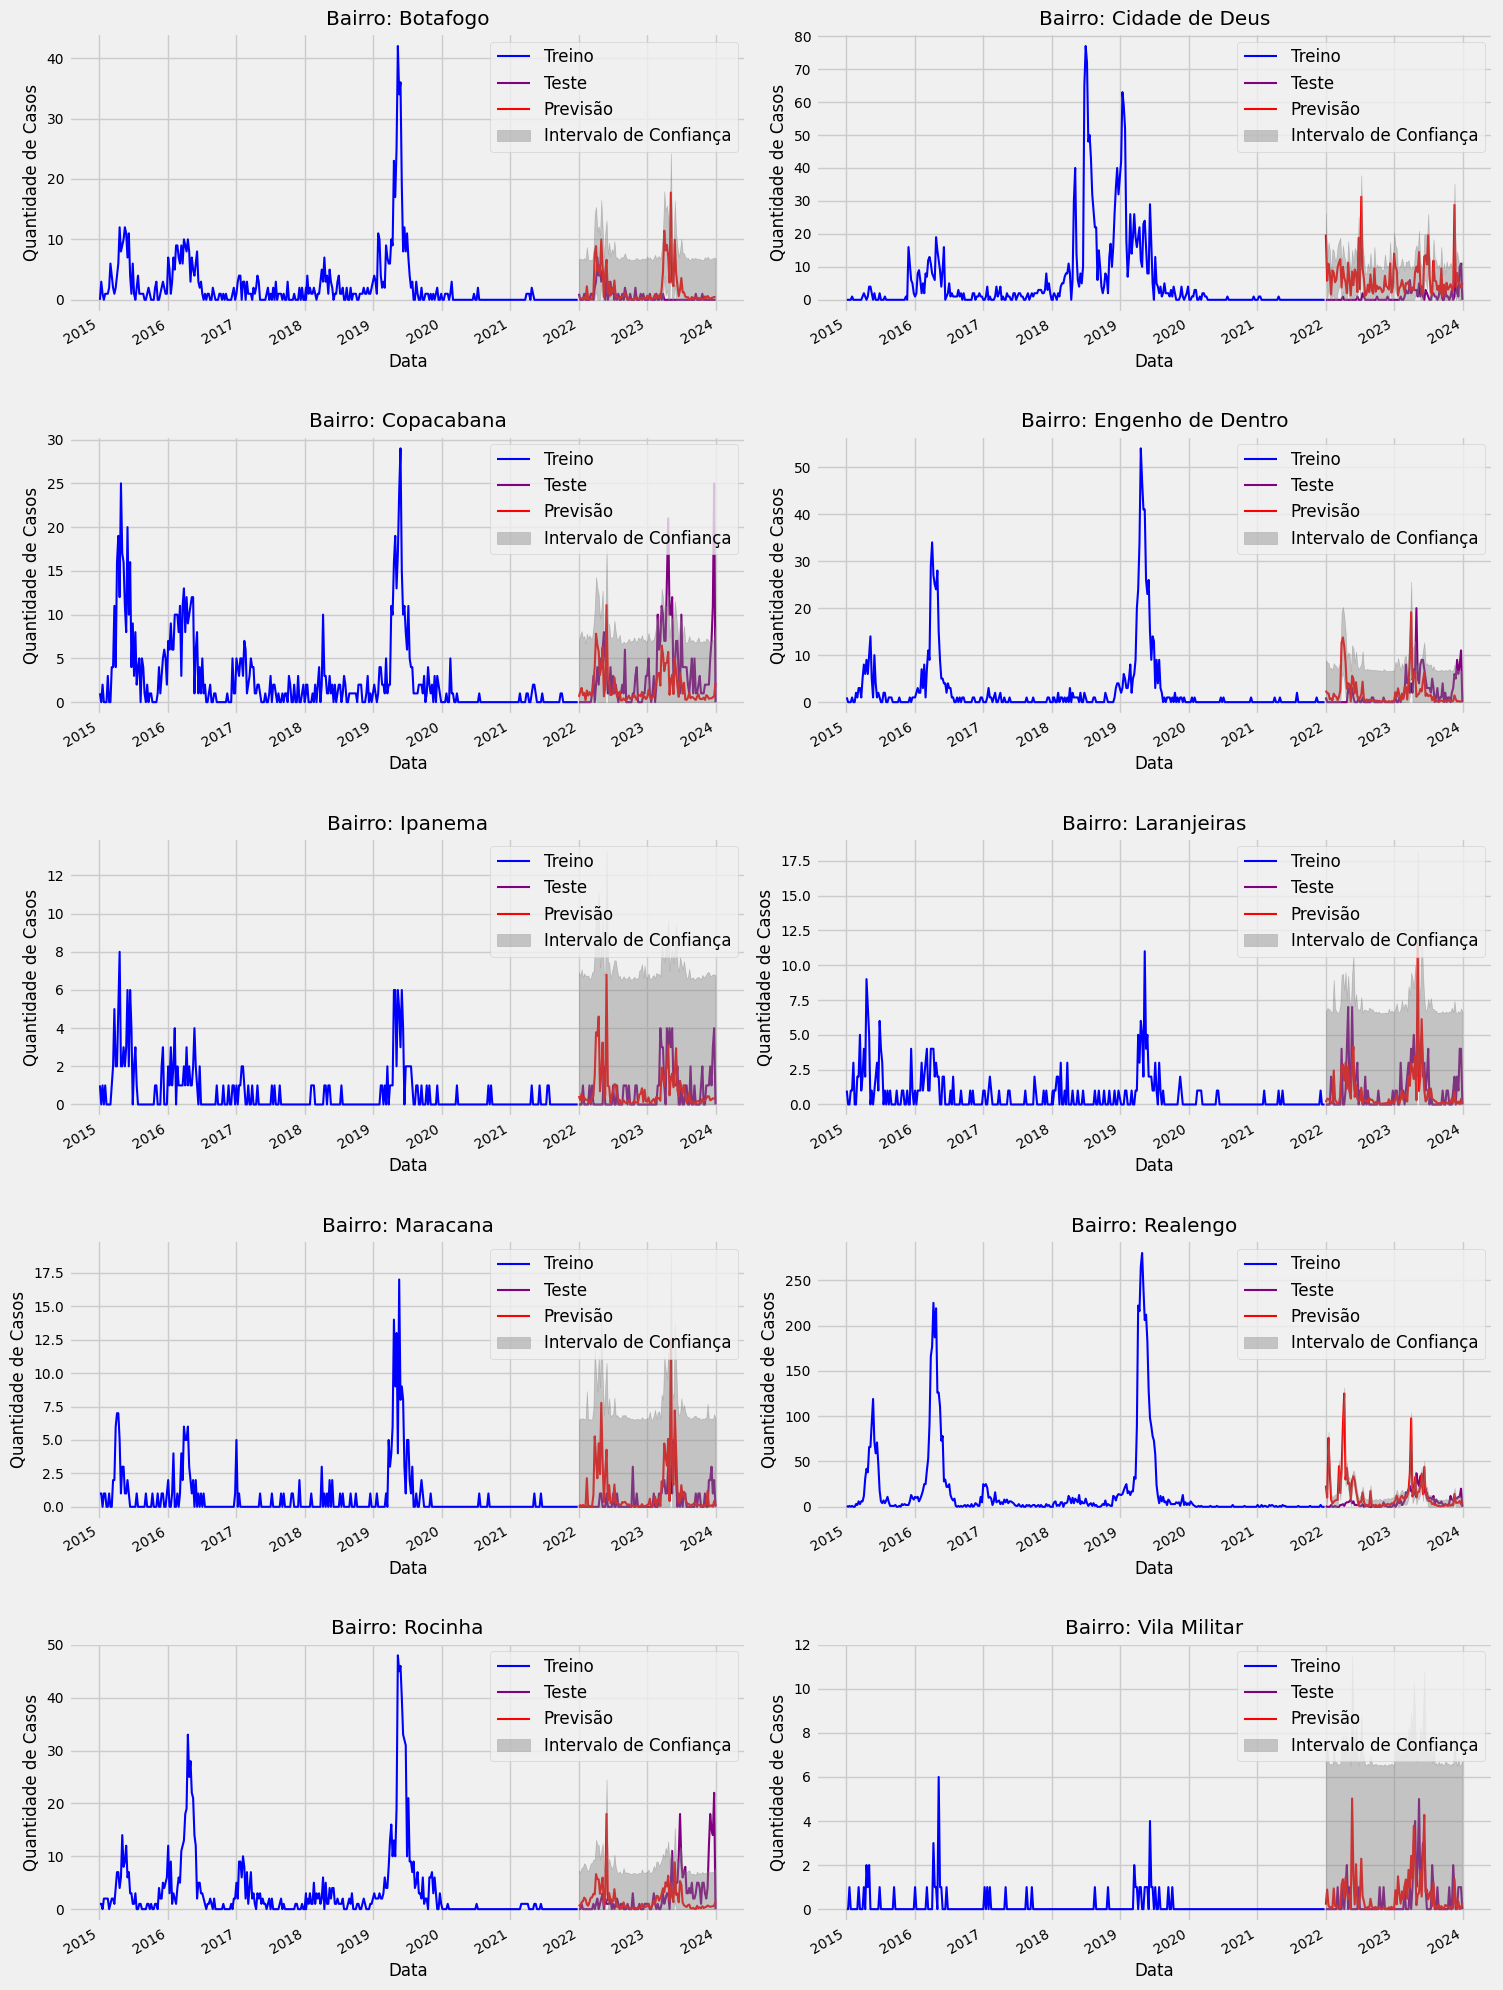

In [29]:
fig, axes = plt.subplots(len(bairros) // 2 + len(bairros) % 2, 2, figsize=(15, len(bairros) * 2), sharex=False)
axes = axes.flatten()

predictions_mapie = pd.Series(predictions_mapie, index=data_test_dates.index)

for i, bairro in enumerate(bairros):
    ax = axes[i]
    
    # Filtrar valores reais, previsões e intervalos para o bairro específico
    mask_train = data_train_dates[f'bairro_{bairro}'] == 1
    mask_test = data_test_dates[f'bairro_{bairro}'] == 1
    
    real_train_values = data_train_dates.loc[mask_train, 'dengueChikungunya']
    real_test_values = data_test_dates.loc[mask_test, 'dengueChikungunya']
    predicted_values = predictions_mapie.loc[mask_test]
    
    # Plotando os dados de treino, teste, previsão e intervalo de confiança para o bairro
    real_train_values.plot(ax=ax, label='Treino', color='blue', zorder=1)
    real_test_values.plot(ax=ax, label='Teste', color='purple', zorder=2)
    ax.plot(real_test_values.index, predicted_values, label='Previsão', color='red', zorder=3)
    
    # Preenchendo o intervalo de confiança
    if intervals.ndim == 2 and intervals.shape[1] == 2:
        lower_bound = pd.Series(intervals[:, 0], index=data_test_dates.index).loc[mask_test]
        upper_bound = pd.Series(intervals[:, 1], index=data_test_dates.index).loc[mask_test]
        ax.fill_between(
            real_test_values.index,
            np.maximum(lower_bound, 0),
            upper_bound,
            color='gray',
            alpha=0.4,
            label='Intervalo de Confiança',
            zorder=4
        )
    
    # Formatando o eixo X para mostrar os anos
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    
    # Definindo os rótulos dos eixos
    ax.set_xlabel('Data')  # Rótulo para o eixo X
    ax.set_ylabel('Quantidade de Casos')  # Rótulo do eixo Y
    ax.set_title(f'Bairro: {bairro}')
    
    # Mostrar a legenda
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize='large')

# Remover quaisquer eixos vazios
for j in range(len(bairros), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição de títulos e rótulos
plt.tight_layout(h_pad=3.0)

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_mapie_treinoTeste_bairros.png', dpi=300)

plt.show()

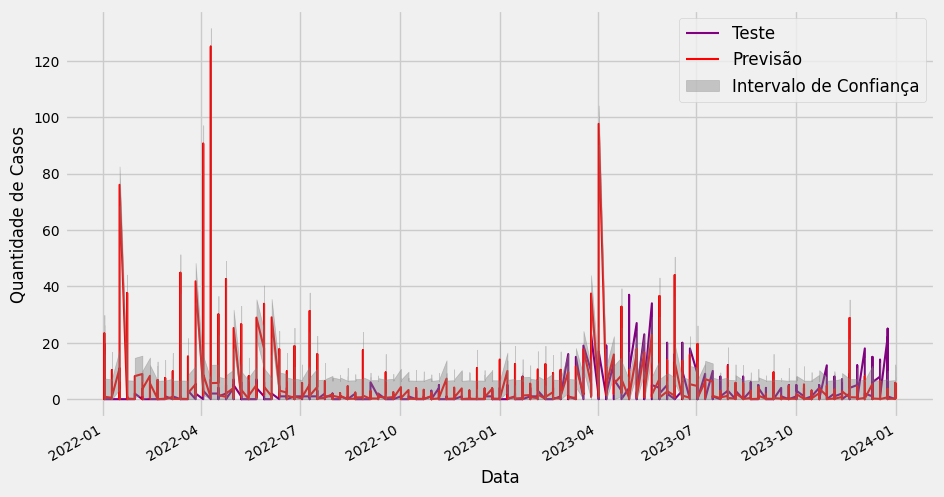

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plotando os dados de teste e previsão
data_test_dates['dengueChikungunya'].plot(ax=ax, label='Teste', color='purple', zorder=2)
ax.plot(data_test_dates.index, predictions_mapie, label='Previsão', color='red', zorder=3)

# Preenchendo o intervalo de confiança
if intervals.ndim == 2 and intervals.shape[1] == 2:
    ax.fill_between(data_test_dates.index, np.maximum(intervals[:, 0], 0), intervals[:, 1], color='gray', alpha=0.4, label='Intervalo de Confiança', zorder=4)

# Formatando os eixos e rotacionando o eixo X
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
fig.autofmt_xdate()

# Adicionando rótulos aos eixos
ax.set_xlabel('Data')  # Rótulo para o eixo X
ax.set_ylabel('Quantidade de Casos')  # Rótulo para o eixo Y

# Definindo a legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', fontsize='large')

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_mapie_teste.png', dpi=300)

# Exibindo o gráfico
plt.show()

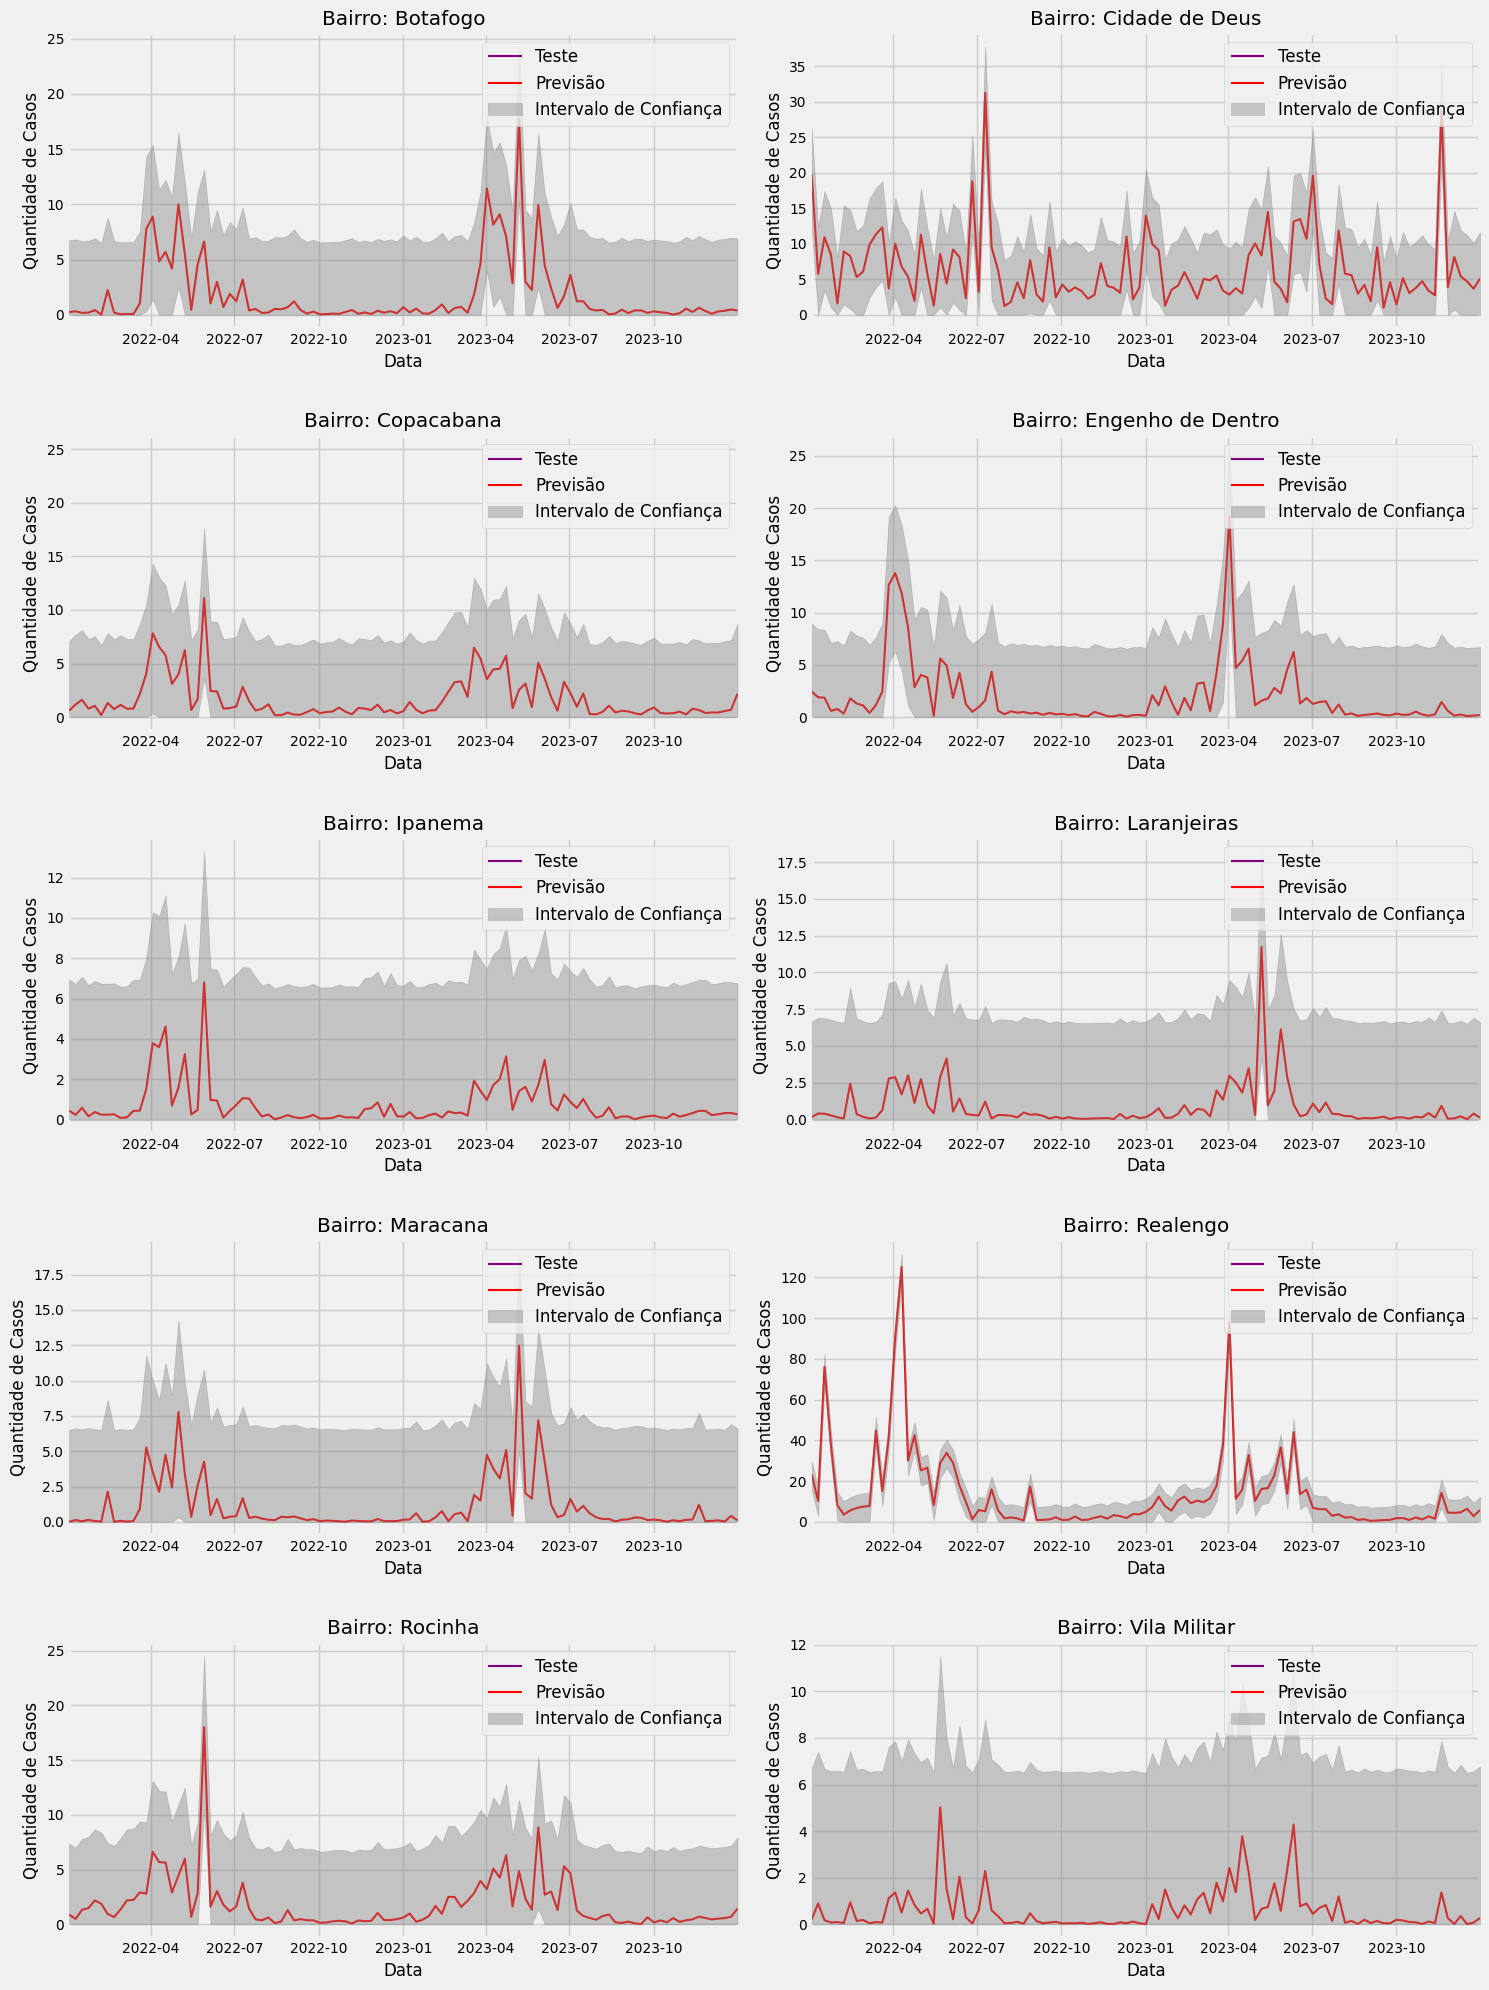

In [31]:
fig, axes = plt.subplots(len(bairros) // 2 + len(bairros) % 2, 2, figsize=(15, len(bairros) * 2), sharex=False)
axes = axes.flatten()

predictions_mapie = pd.Series(predictions_mapie, index=data_test_dates.index)

for i, bairro in enumerate(bairros):
    ax = axes[i]
    
    # Filtrar valores reais, previsões e intervalos para o bairro específico
    #mask_train = data_train_dates[f'bairro_{bairro}'] == 1
    mask_test = data_test_dates[f'bairro_{bairro}'] == 1
    
    real_train_values = data_train_dates.loc[mask_train, 'dengueChikungunya']
    real_test_values = data_test_dates.loc[mask_test, 'dengueChikungunya']
    predicted_values = predictions_mapie.loc[mask_test]
    
    # Plotando os dados de treino, teste, previsão e intervalo de confiança para o bairro
    #real_train_values.plot(ax=ax, label='Treino', color='blue', zorder=1)
    real_test_values.plot(ax=ax, label='Teste', color='purple', zorder=2)
    ax.plot(real_test_values.index, predicted_values, label='Previsão', color='red', zorder=3)
    
    # Preenchendo o intervalo de confiança
    if intervals.ndim == 2 and intervals.shape[1] == 2:
        lower_bound = pd.Series(intervals[:, 0], index=data_test_dates.index).loc[mask_test]
        upper_bound = pd.Series(intervals[:, 1], index=data_test_dates.index).loc[mask_test]
        ax.fill_between(
            real_test_values.index,
            np.maximum(lower_bound, 0),
            upper_bound,
            color='gray',
            alpha=0.4,
            label='Intervalo de Confiança',
            zorder=4
        )
    
    # Formatando o eixo X para mostrar os anos corretamente
    ax.set_xlim(real_test_values.index.min(), real_test_values.index.max())
    ax.xaxis.set_major_locator(AutoDateLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    
    # Definindo os rótulos dos eixos
    ax.set_xlabel('Data')  # Rótulo para o eixo X
    ax.set_ylabel('Quantidade de Casos')  # Rótulo do eixo Y
    ax.set_title(f'Bairro: {bairro}')
    
    # Mostrar a legenda
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='upper right', fontsize='large')

# Remover quaisquer eixos vazios
for j in range(len(bairros), len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout para evitar sobreposição de títulos e rótulos
plt.tight_layout(h_pad=3.0)

# Salvando o gráfico em um arquivo PNG
plt.savefig('./imagens/grafico_mapie_teste_bairros.png', dpi=300)

plt.show()

In [32]:
# Test error
error_mse_mapie = mean_squared_error(data_test_dates['dengueChikungunya'], predictions_mapie)
print(f"Test error (mse): {error_mse_mapie}")

# Calcular o R²
r2_mapie = r2_score(data_test_dates['dengueChikungunya'], predictions_mapie)
print(f"R² do modelo com Mapie: {r2_mapie:.2f}")

Test error (mse): 62.73645304761906
R² do modelo com Mapie: -3.27


In [33]:
# Certificando-se de que intervals tenha duas colunas para os limites inferior e superior
if intervals.ndim == 2 and intervals.shape[1] == 2:
    lower_bound = intervals[:, 0]
    upper_bound = intervals[:, 1]

    # Verificar alinhamento dos índices e fazer comparações
    real_values = data_test_dates['dengueChikungunya'].reindex(data_test_dates.index)

    # Verificar se os valores reais estão dentro do intervalo de confiança
    inside_interval = (real_values >= lower_bound) & (real_values <= upper_bound)

    # Calcular a cobertura como a proporção de valores reais dentro do intervalo
    coverage = inside_interval.mean() * 100

    print(f"Cobertura do intervalo de confiança: {coverage:.2f}%")
else:
    print("Os intervalos não estão no formato correto para o cálculo da cobertura.")

Cobertura do intervalo de confiança: 90.10%


## Analise por Bairro - MAPIE

In [34]:
# Garantir que as previsões do MAPIE estejam alinhadas com o índice de datas
predictions_mapie = pd.Series(predictions_mapie, index=data_test_dates.index)

In [35]:
# Definindo a lista de bairros conforme os nomes gerados pelo OneHotEncoder
bairros = ['Botafogo', 'Cidade de Deus', 'Copacabana', 'Engenho de Dentro', 
           'Ipanema', 'Laranjeiras', 'Maracana', 'Realengo', 'Rocinha', 'Vila Militar']

mse_por_bairro_mapie = {}
r2_por_bairro_mapie = {}

In [36]:
for bairro in bairros:
    # Filtrar os valores reais e as previsões para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    predicted_values = predictions_mapie.loc[mask]
    
    # Calcular o MSE para o bairro específico
    mse = mean_squared_error(y_true=real_values, y_pred=predicted_values)
    mse_por_bairro_mapie[bairro] = mse
    
    # Calcular o R² para o bairro específico
    r2 = r2_score(y_true=real_values, y_pred=predicted_values)
    r2_por_bairro_mapie[bairro] = r2

In [37]:
# Exibir os MSEs e R² por bairro
print("MSE por bairro:")
for bairro, mse in mse_por_bairro_mapie.items():
    print(f"{bairro}: MSE = {mse:.2f}")

print("\nR² por bairro:")
for bairro, r2 in r2_por_bairro_mapie.items():
    print(f"{bairro}: R² = {r2:.2f}")

MSE por bairro:
Botafogo: MSE = 9.87
Cidade de Deus: MSE = 61.53
Copacabana: MSE = 18.93
Engenho de Dentro: MSE = 17.93
Ipanema: MSE = 2.09
Laranjeiras: MSE = 2.19
Maracana: MSE = 3.23
Realengo: MSE = 487.06
Rocinha: MSE = 23.53
Vila Militar: MSE = 1.01

R² por bairro:
Botafogo: R² = -5.36
Cidade de Deus: R² = -15.49
Copacabana: R² = -0.06
Engenho de Dentro: R² = -0.80
Ipanema: R² = -0.79
Laranjeiras: R² = 0.16
Maracana: R² = -2.60
Realengo: R² = -7.03
Rocinha: R² = -0.36
Vila Militar: R² = -0.23


In [38]:
# Garantir que os intervalos estejam alinhados com o índice de datas
intervals_df = pd.DataFrame(intervals, columns=['lower_bound', 'upper_bound'], index=data_test_dates.index)

cobertura_por_bairro_mapie = {}

for bairro in bairros:
    # Filtrando os valores reais e os intervalos para o bairro específico
    mask = data_test_dates[f'bairro_{bairro}'] == 1
    
    # Garantir que a máscara não esteja vazia
    if mask.sum() == 0:
        print(f"Atenção: Nenhum dado encontrado para o bairro {bairro}.")
        cobertura_por_bairro_mapie[bairro] = None
        continue

    real_values = data_test_dates.loc[mask, 'dengueChikungunya']
    lower_bound = intervals_df.loc[mask, 'lower_bound']
    upper_bound = intervals_df.loc[mask, 'upper_bound']
    
    # Alinhamento dos índices, se necessário
    real_values = real_values.reindex(lower_bound.index)

    # Verificar se os valores reais estão dentro do intervalo de confiança
    inside_interval = (real_values >= lower_bound) & (real_values <= upper_bound)
    
    # Calcular a cobertura como a proporção de valores reais dentro do intervalo
    coverage = inside_interval.mean() * 100
    
    cobertura_por_bairro_mapie[bairro] = coverage

# Exibir as coberturas por bairro
for bairro, coverage in cobertura_por_bairro_mapie.items():
    if coverage is not None:
        print(f"{bairro}: Cobertura do intervalo de confiança = {coverage:.2f}%")
    else:
        print(f"{bairro}: Cobertura do intervalo de confiança não calculada (dados ausentes).")

Botafogo: Cobertura do intervalo de confiança = 95.24%
Cidade de Deus: Cobertura do intervalo de confiança = 70.48%
Copacabana: Cobertura do intervalo de confiança = 89.52%
Engenho de Dentro: Cobertura do intervalo de confiança = 90.48%
Ipanema: Cobertura do intervalo de confiança = 100.00%
Laranjeiras: Cobertura do intervalo de confiança = 100.00%
Maracana: Cobertura do intervalo de confiança = 99.05%
Realengo: Cobertura do intervalo de confiança = 65.71%
Rocinha: Cobertura do intervalo de confiança = 90.48%
Vila Militar: Cobertura do intervalo de confiança = 100.00%
